# Distributing a Parcels experiment to a cluster

After some cleanup, we'll reproduce the initial parts of the Parcels tutorial.  Sole change is that we use a few more particles that are randomly distributed across the two eddies.



In [1]:
!rm -fv output_data/*EddyParticles.nc

removed ‘output_data/dask_0000_EddyParticles.nc’
removed ‘output_data/dask_0001_EddyParticles.nc’
removed ‘output_data/dask_0002_EddyParticles.nc’
removed ‘output_data/dask_0003_EddyParticles.nc’
removed ‘output_data/dask_0004_EddyParticles.nc’
removed ‘output_data/dask_0005_EddyParticles.nc’
removed ‘output_data/dask_0006_EddyParticles.nc’
removed ‘output_data/dask_0007_EddyParticles.nc’
removed ‘output_data/dask_10x_0000_EddyParticles.nc’
removed ‘output_data/dask_10x_0001_EddyParticles.nc’
removed ‘output_data/dask_10x_0002_EddyParticles.nc’
removed ‘output_data/dask_10x_0003_EddyParticles.nc’
removed ‘output_data/dask_10x_0004_EddyParticles.nc’
removed ‘output_data/dask_10x_0005_EddyParticles.nc’
removed ‘output_data/dask_10x_0006_EddyParticles.nc’
removed ‘output_data/dask_10x_0007_EddyParticles.nc’
removed ‘output_data/EddyParticles.nc’
removed ‘output_data/serial_0000_EddyParticles.nc’
removed ‘output_data/serial_0001_EddyParticles.nc’
removed ‘output_data/serial_0002_EddyPartic

In [2]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, ScipyParticle, AdvectionRK4, plotTrajectoriesFile
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter

In [3]:
fieldset = FieldSet.from_parcels("input_data/moving_eddies")

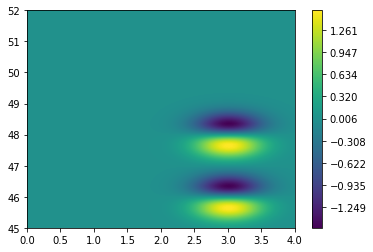

In [4]:
fieldset.U.show(animation=False)

In [5]:
N = 240
lons = 2.0 + 1.5 * np.random.rand(N)
lats = 45.5 + 3.0 * np.random.rand(N)

In [6]:
pset = ParticleSet.from_list(fieldset=fieldset,
                             pclass=JITParticle,
                             lon=lons,
                             lat=lats)

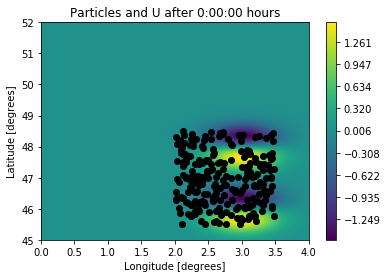

In [7]:
pset.show(field=fieldset.U)

In [8]:
%%time
pset.execute(AdvectionRK4,
             runtime=timedelta(days=5),
             dt=timedelta(minutes=5),
             output_file=pset.ParticleFile(
                 name="output_data/EddyParticles.nc",
                 outputdt=timedelta(hours=1)))

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-320403027/49cd11ad53cdbe70c03ac96050dc95e2.so


CPU times: user 29.2 s, sys: 1 s, total: 30.2 s
Wall time: 31.5 s


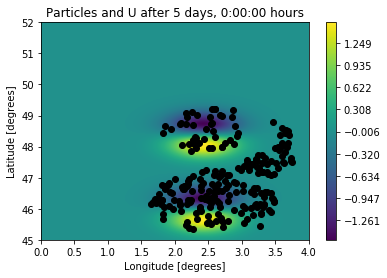

In [9]:
pset.show(field=fieldset.U)

## Wrap whole experiment in a function

As a first step towards parallelization, we wrap the whole experiment in a function with only the essiential args.

Note that there's a `prefix` that will later be used to name the output files in parallel runs.

In [10]:
def run_eddy_exp(lons, lats, prefix):
    fieldset = FieldSet.from_parcels("input_data/moving_eddies")
    
    pset = ParticleSet.from_list(fieldset=fieldset,
                                 pclass=JITParticle,
                                 lon=lons, lat=lats)
    
    pset.execute(AdvectionRK4,
                 runtime=timedelta(days=5),
                 dt=timedelta(minutes=5),
                 output_file=pset.ParticleFile(
                     name="output_data/{}EddyParticles.nc".format(prefix),
                     outputdt=timedelta(hours=1)))

## Rerun wrapped experiment

Execution times should be identical.

In [11]:
%%time
run_eddy_exp(lons, lats, "wrapped_")

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-320403027/4c9fff5cdea14fe1ca1da81e33523b19.so


CPU times: user 30.2 s, sys: 876 ms, total: 31.1 s
Wall time: 32.5 s


## First step towards distribution: Split into independent tasks

Map the experiment to only subsets of the initial positions.

In [12]:
%%time
experiments = map(run_eddy_exp,
                  np.split(lons, 8),
                  np.split(lats, 8),
                  ("serial_{:04d}_".format(n) for n in range(8)))
e = list(experiments);

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-320403027/99780b3f0d8a0dca10f2b48dece75b3d.so
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-320403027/4edbd9811bf220ba89cf3e2bf4364a0d.so
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-320403027/5418705da8a71cc13a0631bf9a8481b0.so
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-320403027/64afe44d060560b1cf1b9ac891f8ed7c.so
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-320403027/dd78cf9b748cc549268966dc9ab8d1c3.so
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-320403027/654fe355817b63d362a180ca37bbf44e.so
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-320403027/036efeb473d6df51da84bd27482f2658.so
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-320403027/73bf258f23794a8cf60cac1325e25d42.so


CPU times: user 32.5 s, sys: 7.2 s, total: 39.7 s
Wall time: 51.4 s


## Distribute with dask

We spin up a (local) cluster with `dask.distributed` and use `dask.bag` to map the experiment to a sequence of parameters living on this cluster.

In [13]:
from dask.distributed import Client

In [14]:
client = Client(n_workers=8, threads_per_worker=1, memory_limit=2e9)
client

Client Scheduler: tcp://127.0.0.1:36457 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 16.00 GB


In [15]:
import dask.bag as db

In [16]:
%%time
experiments = db.from_sequence(
    zip(np.split(lons, 8),
        np.split(lats, 8),
        ("dask_{:04d}_".format(n) for n in range(8)))
).map(lambda p: run_eddy_exp(*p))
e = experiments.compute();

CPU times: user 729 ms, sys: 116 ms, total: 846 ms
Wall time: 9.23 s


On eight CPUs of a VM, this only took about 30% of the time it took for serial execution in  a single experiment.

## Scale up by a factor of 4

In [17]:
N = 240 * 4
lons = 2.0 + 1.5 * np.random.rand(N)
lats = 45.5 + 3.0 * np.random.rand(N)

In [22]:
%%time
experiments = db.from_sequence(
    zip(np.split(lons, 8),
        np.split(lats, 8),
        ("dask_4x_{:04d}_".format(n) for n in range(8)))
).map(lambda p: run_eddy_exp(*p))
e = experiments.compute();

CPU times: user 2.56 s, sys: 211 ms, total: 2.77 s
Wall time: 20.8 s


In [23]:
%%time
run_eddy_exp(lons, lats, "wrapped_4x_");

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-320403027/042fc76090a8569f1af3f7cea6a37373.so


CPU times: user 2min 11s, sys: 6.56 s, total: 2min 17s
Wall time: 2min 15s


So for a slightly longer experiment, we get a gain of (6.75) which is almost proportional to the number of workers (8) we used.

## Check output

In [25]:
!ls -1 output_data/*.nc

output_data/dask_0000_EddyParticles.nc
output_data/dask_0001_EddyParticles.nc
output_data/dask_0002_EddyParticles.nc
output_data/dask_0003_EddyParticles.nc
output_data/dask_0004_EddyParticles.nc
output_data/dask_0005_EddyParticles.nc
output_data/dask_0006_EddyParticles.nc
output_data/dask_0007_EddyParticles.nc
output_data/dask_4x_0000_EddyParticles.nc
output_data/dask_4x_0001_EddyParticles.nc
output_data/dask_4x_0002_EddyParticles.nc
output_data/dask_4x_0003_EddyParticles.nc
output_data/dask_4x_0004_EddyParticles.nc
output_data/dask_4x_0005_EddyParticles.nc
output_data/dask_4x_0006_EddyParticles.nc
output_data/dask_4x_0007_EddyParticles.nc
output_data/EddyParticles.nc
output_data/serial_0000_EddyParticles.nc
output_data/serial_0001_EddyParticles.nc
output_data/serial_0002_EddyParticles.nc
output_data/serial_0003_EddyParticles.nc
output_data/serial_0004_EddyParticles.nc
output_data/serial_0005_EddyParticles.nc
output_data/serial_0006_EddyParticles.nc
output_data/serial_0007_EddyParticle